## <font style="font-family:roboto;color:#455e6c"> Achieving reproducible and reusable workflows </font>  

We will use [pyiron_workflow](https://github.com/pyiron/pyiron_workflow), a framework for constructing workflows as computational graphs from simple python functions, to create a simple workflow for data analysis. Coverting your script to a workflow that you can use a number of powerful features that pyiron provides, such as data management, job management, at the same time ensuring that they are fully reproducible.

In this example, we will use a very common use case in Materials Science, which is to use data from a [tensile test](https://en.wikipedia.org/wiki/Tensile_testing) to calculate the [Youngs modulus](https://en.wikipedia.org/wiki/Young%27s_modulus).



We start from a datafile in csv format. The file containes data from a tensile test of typical S355 (material number: 1.0577) structural steel (designation of steel according to DIN EN 10025-2:2019). The data were generated in the [Bundesanstalt für Materialforschung und -prüfung (BAM)](https://zenodo.org/communities/bam) in the framework of the digitization project [Innovationplatform MaterialDigital (PMD)](https://www.materialdigital.de/) which, amongst other activities, aims to store data in a semantically and machine understandable way. 

### References

- Schilling, M., Glaubitz, S., Matzak, K., Rehmer, B., & Skrotzki, B. (2022). Full dataset of several mechanical tests on an S355 steel sheet as reference data for digital representations (1.0.0) [Data set](https://doi.org/10.5281/zenodo.6778336)

Let's start with the visualisation of how such a workflow would look like:

<img src="workflow-dpg.png" width="700">

In the tensile test experiment, the force (load) and elongation values are recorded, and saved in a csv file which forms the dataset. We would like to read in this dataset, and convert the load and elongation to stress and strain. Then we plot the results, and calculate a the Young's modulus, which is the slope of the linear, elastic part of the stress-strain curve. Your calculation could depend on the value of this strain-cutoff that is used, which is something we will explore. 

To create such a workflow, we start by defining some functions which does each of this step. We will use 'pyiron_workflow' to compose them into a workflow, which can then be easily visualised and executed.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyiron_base import Project
from pyiron_workflow import Workflow, job

### Reading in the experimental results

This function reads in the csv file, and in addition, the cross sectional area. The load is converted to stress in MPa, and the stress and strain values are returned.

In [2]:
@Workflow.wrap_as.function_node()
def ReadInput(filename, area):
    """
    Read in csv file, convert load to stress
    """
    kN_to_N = 0.001  # convert kiloNewton to Newton
    mm2_to_m2 = 1e-6  # convert square millimeters to square meters
    df = pd.read_csv(filename, delimiter=";", header=[0, 1], decimal=",")
    df["Stress"] = df["Load"] * kN_to_N / (area * mm2_to_m2)
    strain = df["Extensometer elongation"].values.flatten()
    stress = df["Stress"].values.flatten()
    return stress, strain

### Calculate Youngs modulus

The stress and strain values, which are outputs of the previous function is used for a linear fit in this function, and the slope is calculated. The slope is the Young's modulus. The calculated value of Young's modulus will depend on the `strain_cutoff` parameter.

In [3]:
@Workflow.wrap_as.function_node()
def CalculateYoungsModulus(stress, strain, strain_cutoff=0.2):
    percent_to_fraction = 100  # convert
    MPa_to_GPa = 1 / 1000  # convert MPa to GPa
    arg = np.argsort(np.abs(np.array(strain) - strain_cutoff))[0]
    fit = np.polyfit(strain[:arg], stress[:arg], 1)
    youngs_modulus = fit[0] * percent_to_fraction * MPa_to_GPa
    return youngs_modulus

### Plotting the results

This function plots the stress and strain.

In [4]:
@Workflow.wrap_as.function_node()
def Plot(stress, strain, format="-"):
    plt.plot(strain, stress, format)
    plt.xlabel("Strain [%]")
    plt.ylabel("Stress [MPa]")
    return 1

### Creating a workflow

Now we can combine all the functions together to compose a workflow. Each function corresponds to a step in the workflow and their inputs and outputs are linked.

In [5]:
wf = Workflow("youngs_modulus")
wf.strain_cutoff = Workflow.create.standard.UserInput(float)
wf.read_input = ReadInput()

wf.youngs_modulus = CalculateYoungsModulus(
    stress=wf.read_input.outputs.stress,
    strain=wf.read_input.outputs.strain,
)

wf.plot = Plot(
    stress=wf.read_input.outputs.stress,
    strain=wf.read_input.outputs.strain,
)

Now we execute the workflow

{'strain_cutoff__user_input': float,
 'youngs_modulus__youngs_modulus': 188.4145327564869,
 'plot__1': 1}

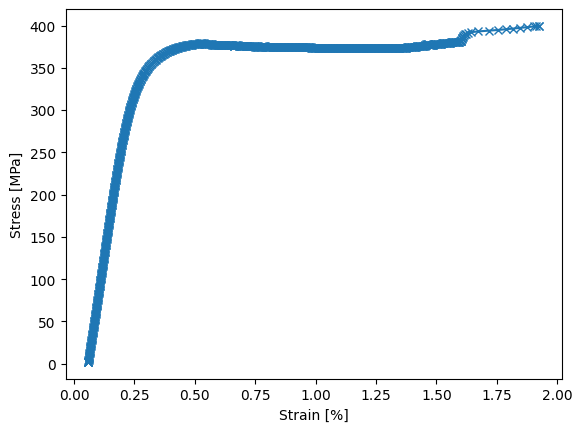

In [6]:
wf(
    read_input__filename="dataset_1.csv",
    read_input__area=120.636,
    plot__format="-x",
)

We can also visualise the workflow. The visualisation shows the different steps, and their inputs and outputs and how they are linked together.

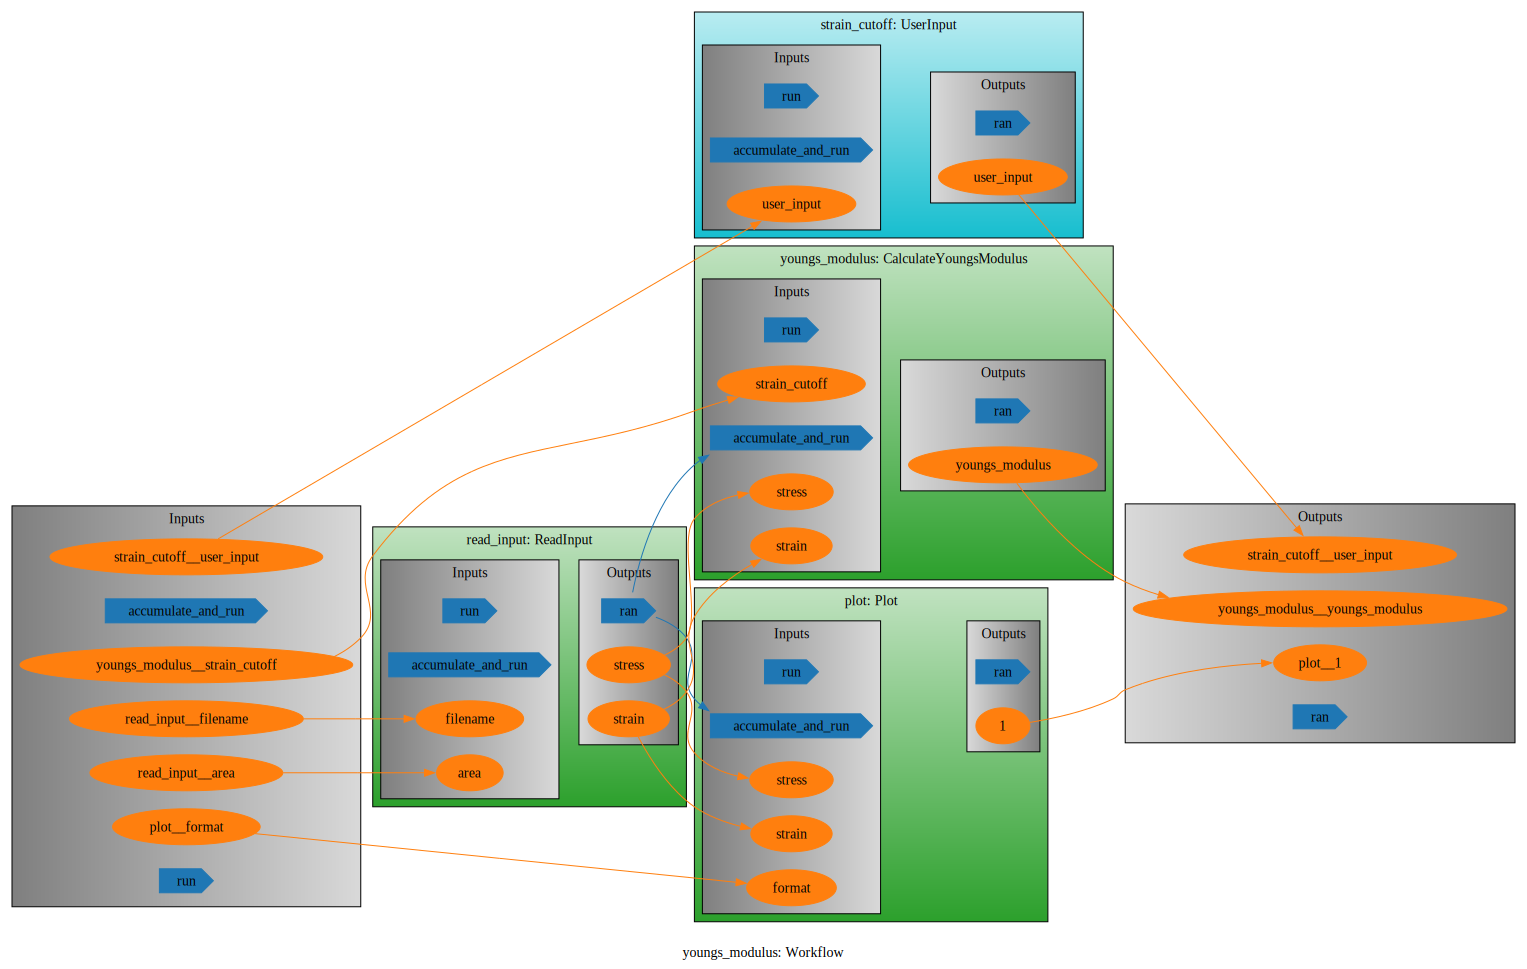

In [7]:
wf.draw()

### Making a reusable workflow

Now that we have a workflow, we can convert it to a Macro, which is a resuable instance. Macros provide three advantages:

- Reusability: the macro can be used with different input parameters
- Composable: the macro can be integrated into other workflows as a step
- Shareable: it can be shared with others, who can in turn run it

The macro looks very much like the workflow we composed before.

In [8]:
@Workflow.wrap_as.macro_node("youngs_modulus", "strain_cutoff")
def YoungsModulus(wf, filename, area, strain_cutoff):
    wf.read_input = ReadInput(filename, area)
    wf.youngs_modulus = CalculateYoungsModulus(
        stress=wf.read_input.outputs.stress,
        strain=wf.read_input.outputs.strain,
        strain_cutoff=strain_cutoff,
    )
    return wf.youngs_modulus.outputs.youngs_modulus, strain_cutoff


modulus = YoungsModulus(
    filename="dataset_1.csv", area=120.636
)

let's see how we can run the macro

In [9]:
modulus(strain_cutoff=0.2)

{'strain_cutoff': 0.2, 'youngs_modulus': 188.4145327564869}

### Scaling up calculations

Although this example is easy and fast to run, it represents a common type of problem. For example, we would like to understand the impact of the parameter `strain_cutoff` on the calculated Young's modulus. Often, the calculations are computationally intensive, and would need to be paralellised. For this, we can use `pyiron Project`. A `Project` is a collection of `Job`s which can be easily scaled. The macro that we composed can be easily converted to a Job. 

In [10]:
pr = Project("stress-strain-project")

In [11]:
job = pr.create.job.NodeJob("youngs_modulus")
job.input["node"] = modulus

Now we can simply call the `run` function to execute the job

In [12]:
job.run()

The job _node_outf1889f618e776ca29e102a033ef86760 was saved and received the ID: 2370


The output can be accessed as follows:

In [13]:
job.output.youngs_modulus

188.4145327564869

Now we will vary the `strain_cutoff` to find an optimal value. There are [many methods](https://www.degruyter.com/document/doi/10.3139/120.110269/html?lang=de) to do this and usually the result depends on the method. Here, we will simply choose a range of strain cutoff values, and run our Job at each of them. We will choose 20 values from the range 0.01 to 0.6.

In [14]:
for x in np.linspace(0.05, 0.6, 20):
    job = pr.create.job.NodeJob(f"job_{np.round(x, 4)}")
    job.input["node"] = YoungsModulus(
        filename="dataset_1.csv",
        area=120.636,
        strain_cutoff=x,
    )
    job.run()

The job _node_out2a4025981c5d621d280e4103d12182e2 was saved and received the ID: 2371


/tmp/ipykernel_2071/4272250088.py:6: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(strain[:arg], stress[:arg], 1)


The job _node_outb278b9271d31353a40e4889aa0e1edd4 was saved and received the ID: 2372
The job _node_outa5d60c62ebcff68820811969dfba9f8b was saved and received the ID: 2373
The job _node_out609a7bd01dbadc132d6daaa9c5271d5f was saved and received the ID: 2374
The job _node_out8cd97c1b572cac281914f0ed89eb2080 was saved and received the ID: 2375
The job _node_out696bb48622c3cae875ac7012c89ae2da was saved and received the ID: 2376
The job _node_outcad00c3dc5f0c027aaaee4eb68deae4c was saved and received the ID: 2377
The job _node_out1b15844ab279ab423be41b5c0b18d313 was saved and received the ID: 2378
The job _node_out58facd49ed532ff3dac9f16d940c1356 was saved and received the ID: 2379
The job _node_out3de9c714750ee5ea3dd50844ae865273 was saved and received the ID: 2380
The job _node_outcd90eeba1845864797497a87139ccfe5 was saved and received the ID: 2381
The job _node_out311efa8795debe0c4aa9d4f122fc17c5 was saved and received the ID: 2382
The job _node_out784cab957c1d93ecb193957a0cda7792 was 

### The pyiron job table

pyiron offers a feature to check your jobs at a glance

In [15]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,2370,finished,None,_node_outf1889f618e776ca29e102a033ef86760,/_node_outf1889f618e776ca29e102a033ef86760,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:05:58.759913,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
1,2371,finished,None,_node_out2a4025981c5d621d280e4103d12182e2,/_node_out2a4025981c5d621d280e4103d12182e2,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:05:59.219837,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
2,2372,finished,None,_node_outb278b9271d31353a40e4889aa0e1edd4,/_node_outb278b9271d31353a40e4889aa0e1edd4,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:05:59.737479,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
3,2373,finished,None,_node_outa5d60c62ebcff68820811969dfba9f8b,/_node_outa5d60c62ebcff68820811969dfba9f8b,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:00.165415,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
4,2374,finished,None,_node_out609a7bd01dbadc132d6daaa9c5271d5f,/_node_out609a7bd01dbadc132d6daaa9c5271d5f,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:00.612857,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
5,2375,finished,None,_node_out8cd97c1b572cac281914f0ed89eb2080,/_node_out8cd97c1b572cac281914f0ed89eb2080,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:01.054400,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
6,2376,finished,None,_node_out696bb48622c3cae875ac7012c89ae2da,/_node_out696bb48622c3cae875ac7012c89ae2da,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:01.510465,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
7,2377,finished,None,_node_outcad00c3dc5f0c027aaaee4eb68deae4c,/_node_outcad00c3dc5f0c027aaaee4eb68deae4c,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:01.932017,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
8,2378,finished,None,_node_out1b15844ab279ab423be41b5c0b18d313,/_node_out1b15844ab279ab423be41b5c0b18d313,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:02.364964,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None
9,2379,finished,None,_node_out58facd49ed532ff3dac9f16d940c1356,/_node_out58facd49ed532ff3dac9f16d940c1356,None,/mnt/c/Users/menon/Documents/winrepos/projects-ideas/dpg_tutorial_2024/workflows/stress-strain-project-3/,2024-02-27 16:06:02.831760,None,None,pyiron@cmleo26#1,NodeJob,0.4,None,None


You can see that all the jobs we ran are indexed there along with the associated metadata. This is a powertool tool with which we can do further analysis. We will collect the value of Young's modulus and strain cutoff and plot them.

First we create a pyiron table

In [16]:
table = pr.create.table(delete_existing_job=True)

Now we need to add some conditions to add data to the table. We create two functions that will extract the Young's modulus and strain cutoff:

In [17]:
def youngs_modulus(job):
    return job["storage/output"]["youngs_modulus"]


def strain_cutoff(job):
    return job["storage/output"]["strain_cutoff"]

We can apply them on the table:

In [18]:
table.add["youngs_modulus"] = youngs_modulus
table.add["strain_cutoff"] = strain_cutoff
table.run()

The job table was saved and received the ID: 2391


Processing jobs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.75it/s]
/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:643: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(
/home/menon/miniconda3/envs/pyiron-workflow/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:643: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(


and we extract the results.

In [19]:
df = table.get_dataframe().sort_values(by="strain_cutoff")
df

,job_id,youngs_modulus,strain_cutoff
1,2371,1.802219,0.050000
2,2372,191.111654,0.078947
3,2373,189.953332,0.107895
4,2374,192.315615,0.136842
5,2375,192.129384,0.165789
6,2376,189.263823,0.194737
0,2370,188.414533,0.200000
7,2377,183.458314,0.223684
8,2378,175.862063,0.252632
9,2379,167.541057,0.281579


Finally we can plot it and see how the value of Young's modulus changes with the selected strain cutoff. 

Text(0, 0.5, "Young's modulus [MPa]")

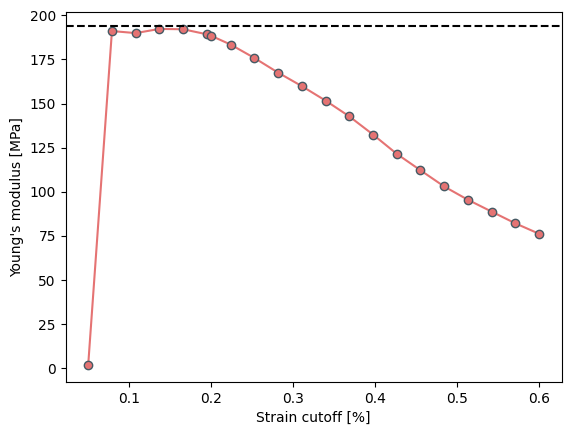

In [20]:
plt.plot(
    df.strain_cutoff,
    df.youngs_modulus,
    "o-",
    color="#e57373",
    markeredgecolor="#455a64",
)
plt.axhline(194, color="black", ls="dashed")
plt.xlabel("Strain cutoff [%]")
plt.ylabel("Young's modulus [MPa]")

The experimental value is marked in black dashed line. As you can see, a very low range gives the wrong results, as we do not have much data for strain cutoff less than 0.05. At a high value of strain cutoff, the non-elastic region is also included in the calculation, which then leads to wrong results.